In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer() # create the instance

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.sentiment import SentimentIntensityAnalyzer
SIA= SentimentIntensityAnalyzer() # create the instance

[nltk_data] Downloading package punkt to C:\Users\hchih...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\hchih...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get dialogue dataframe
def get_dialogue(script):
    raw= []    
    if '#' in script[0]:
        for n, para in enumerate(script):
#             if n<20:
                if '#' in para: pass
                else: raw.append(para)
                    
    else: 
        for n, para in enumerate(script):
#             if n<20:
                dp= []
                for i, ele in enumerate(para):
                    if ele== '[': 
                            dp.append(i-1) 
                    elif ele== ']': 
                            dp.append(i+2)
                if (len(dp)== 0):
                    if len(para)== 1: # no content no [] 
                        pass
                    else: 
                        raw.append(para) # content with no [] 
                elif (len(dp)!= 0) and (dp[0]== -1):
                    pass
                else:
                    for i in range(len(dp), 0, -2):
                        para= para.replace(para[dp[i-2]:dp[i-1]-1],' ')
                    raw.append(para)
    return raw

In [3]:
# turn to dataframe 
def to_df(scripts):    
    # seperate character & lines, save to dataframe
    chct_lst= []
    ln_lst=[]    
    for i, script in enumerate(scripts):
        if i<30:
            for n, para in enumerate(script):             
                para= para.lower().replace('\n',' ')
                if len(para.split(':'))== 2:
                    chct= para.split(':', 1)[0]
                    chct_lst.append(chct)
                    line= para.split(':', 1)[1]
                    ln_lst.append(line)
    df= pd.concat([pd.DataFrame({'Character': chct_lst}),
                pd.DataFrame({'Line': ln_lst})], axis= 1)
    
    # name integration
    df['Character'].replace({'iron man': 'tony stark', 'tony': 'tony stark',
                    'natasha': 'natasha romanoff', 'black widow': 'natasha romanoff', 
                    'captain america': 'steve rogers', 'steve': 'steve rogers',
                    'james barnes': 'bucky barnes', 'winter soldier': 'bucky barnes', 
                    'hawkeye': 'clint barton', 'clint': 'clint barton',
                    'bruce': 'bruce banner', 'hulk': 'bruce banner',
                    't\'challa': 'black panther',
                    'fury': 'nick fury',
                    'peter parker': 'spider man', 'rocket raccoon': 'rocket',
                    'scott': 'scott lang', 
                    'carol': 'captain marvel',
                    'dr. strange': 'dr strange', 'dr. stephen strange': 'dr strange', 'doctor stephen strange': 'dr strange', 'doctor strange': 'dr strange',
                    'pepper': 'pepper potts'
                         }, inplace= True)
    return df

In [4]:
# clean dialogue with nltk
def get_cleandf(df):
    tknzr= RegexpTokenizer('\w+')

    # tokenize & count
    df['Line']= df['Line'].apply(lambda para: ' '.join(sent_tokenize(para)) )
    df.insert(2, column='Line Count', value= df['Line'].apply(lambda para: len(sent_tokenize(para)) ))
    df.insert(3, column='Word Count', value= df['Line'].apply(lambda para: len(para.split())))
    
    # remove punctuation, remove stopword, stem
    df['Line']= df['Line'].apply(lambda para: ' '.join(tknzr.tokenize(para)))\
    .apply(lambda para: ' '.join(word for word in para.split() if word not in stopwords.words('english')))\
    .apply(lambda para: ' '.join(stemmer.stem(word) for word in para.split()))
    
    df.insert(4, column="Sentiment Score", value= df['Line'].apply(lambda sent: SIA.polarity_scores(sent)['compound']))

    return df

In [5]:
# set main characters statistics and generate plot
def to_plot(df):
    main_char= ['tony stark', 'natasha romanoff', 'thor', 'loki', 'steve rogers', 'clint barton',\
                 'bruce banner','black panther', 'spider man', 'scott lang', 'captain marvel',\
                 'dr strange', 'peter quill', 'wanda maximoff', 'nick fury', 'pepper potts',\
                 'bucky barnes', 'vision']
    mvchar_group= df[df['Character'].isin(main_char)].groupby('Character')
    
    fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
    mvchar_group['Line Count'].sum().sort_values().plot(kind='barh', title= 'Line Count of Main Character', figsize= (10, 18), color= 'gold', ax= ax)
    mvchar_group['Word Count'].sum().sort_values().plot(kind='barh', title= 'Word Count of Main Character', figsize= (10, 18), color= 'lightblue', ax= ax2)
    mvchar_group['Sentiment Score'].mean().sort_values().plot(kind='barh', title= 'Avarage Sentiment of Main Character', figsize= (10, 18), color= 'aquamarine', ax= ax3)
    fig.tight_layout() # adjust subplot automatically

In [6]:
files= os.listdir('../python ntlk movie script')
raw_scripts= []
for i, file_name in enumerate(files): 
#     if i<= 10:
        if file_name.endswith(".txt"):
            f= open(file_name, encoding= 'UTF-8-sig')
            script= f.readlines()
            raw_scripts.append(get_dialogue(script)) # append each script
            f.close()

rawdf= to_df(raw_scripts)
cleandf= get_cleandf(rawdf)
cleandf

,Character,Line,Line Count,Word Count,Sentiment Score
0,dr. hank pym,stark,1,1,0.0000
1,mitchell carson,seem happi,1,4,0.0000
2,howard stark,hello hank suppos moscow,2,8,0.0000
3,dr. hank pym,took detour defens lab,2,8,0.0000
4,peggy carter,tell think,1,9,0.0000
...,...,...,...,...,...
15038,darcy,go,1,3,0.0000
15039,jane,thank jane insert flash drive devic,2,9,0.3612
15040,darcy,would come back could,1,8,0.0000
15041,jane,know get jane hit switch devic suddenli 3 holo...,4,47,0.0000


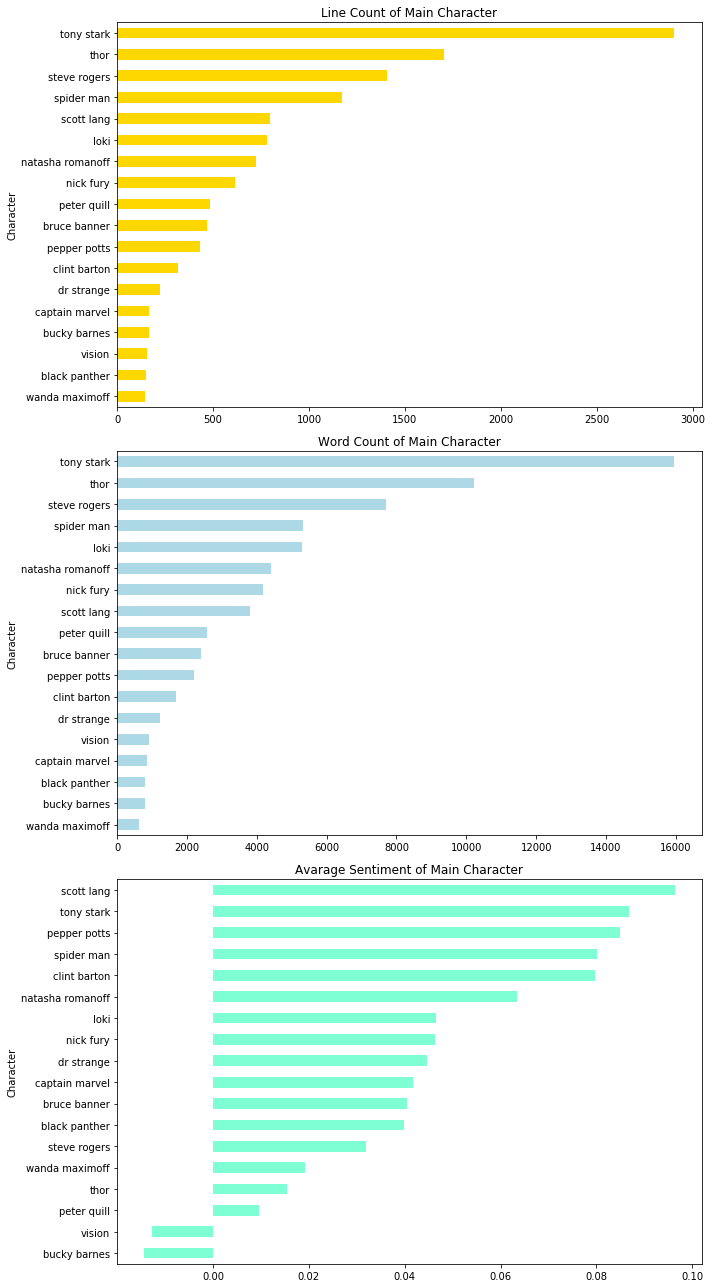

In [7]:
to_plot(cleandf)